# Task 1
We are provided with 100 images, accompanied with a csv file containing information about each object in the image. The objective is to classify the images into 5 classes
The dataset describes a **driving scenario with a car changing lanes from center to right lane, along with other cars in the scene**
For each image in the dataset, the information about the ego car is given as defined in the $X_{ego}$ as follows:
$$X_{ego} = [lane, d_{right}, d_{left}, vel, acc, yaw]$$

For every image, there is a single $X_{ego}$ vector, while there are a changing number of vectors describing the objects for each image (depending on the number of objects).
In the first task, it is possible to choose which columns to use for clustering. So I chose to classify the images based on the ego car information only. This will classify images based on the state of the ego car only.

The process will be as follows:
1. Data preprocessing: 
    - Load the data
    - Link each image to its corresponding $X_{ego}$ vector (remove duplicates)
2. Use a simple autoencoder to reduce the dimensionality of the data    
3. Use K-means to cluster encoder latent space into 5 clusters

## Data Preprocessing

In [13]:
# PARAMETERS
K = 5  # number words in BoW representation
LATENT_DIM = 2  # number of autoencoder latent dimensions
EPOCHS = 200   # number of training epochs
BATCH_SIZE = 2 # number of training samples per batch

In [14]:
import sklearn
import numpy as np
import csv
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib widget

# read the corpus
# ---------------
with open('data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    data = list(reader)

data = np.array(data[1:]) # remove header
image_ids, csv_indices = np.unique(data[:,0], return_index=True) # get unique image ids and their indices

# create a dictionary mapping image ids to their indices
image_index_to_id = {i: image_id for i, image_id in enumerate(image_ids)}

# load a ego vector for each image
# --------------------------------
ego_vectors = np.zeros((len(image_ids), 6))
for i, csv_index in enumerate(csv_indices):
    ego_vectors[i, :] = data[csv_index, -6:].astype(np.float32)

print('ego_vectors.shape:', ego_vectors.shape)

ego_vectors.shape: (100, 6)


## Autoencoder
The dataset now contains 100 $X_{ego}$ vectors.
<img src="images/autoencoder.webp" width="400"/>

Now we will use a simple autoencoder to reduce the dimensionality of the data.
The input of the autoencoder is the $X_{ego}$ vector of size 6.
Another layer will be added to the autoencoder to reduce the dimensionality of the data to 2.

In [15]:
import torch
import torch.nn as nn

# Define the autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 3),
            nn.ReLU(),
            nn.Linear(3, latent_dim),
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 3),
            nn.ReLU(),
            nn.Linear(3, input_dim),
        )
    
        # initialize the weights
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.5)

    def forward(self, x):
        # Encode the input
        encoded = self.encoder(x)
        
        # Decode the encoded input
        decoded = self.decoder(encoded)
        
        return encoded, decoded

# Create an instance of the autoencoder
input_dim = ego_vectors.shape[1]  # Input dimension
latent_dim = LATENT_DIM  # Latent dimension

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = Autoencoder(input_dim, latent_dim)
autoencoder.to(device)
# Print the autoencoder architecture
print(autoencoder)


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=6, bias=True)
  )
)


## Training the Autoencoder


model saved
Epoch [1/200], Loss: 36.9563
model saved
Epoch [2/200], Loss: 13.3019
model saved
Epoch [3/200], Loss: 11.8045
Epoch [4/200], Loss: 18.9287
Epoch [5/200], Loss: 17.5211
model saved
Epoch [6/200], Loss: 6.6330
Epoch [7/200], Loss: 12.7753
model saved
Epoch [8/200], Loss: 1.7484
Epoch [9/200], Loss: 2.4983
Epoch [10/200], Loss: 2.1870
Epoch [11/200], Loss: 4.7363
Epoch [12/200], Loss: 2.0450
Epoch [13/200], Loss: 2.6901
Epoch [14/200], Loss: 2.6369
model saved
Epoch [15/200], Loss: 1.2546
Epoch [16/200], Loss: 1.8150
Epoch [17/200], Loss: 2.9753
Epoch [18/200], Loss: 2.1284
Epoch [19/200], Loss: 1.5066
Epoch [20/200], Loss: 1.7944
Epoch [21/200], Loss: 1.9755
model saved
Epoch [22/200], Loss: 0.7156
Epoch [23/200], Loss: 2.4151
Epoch [24/200], Loss: 1.8874
model saved
Epoch [25/200], Loss: 0.2781
Epoch [26/200], Loss: 2.4427
Epoch [27/200], Loss: 1.8581
Epoch [28/200], Loss: 1.3681
Epoch [29/200], Loss: 0.5878
Epoch [30/200], Loss: 4.3586
Epoch [31/200], Loss: 0.9221
Epoch [3

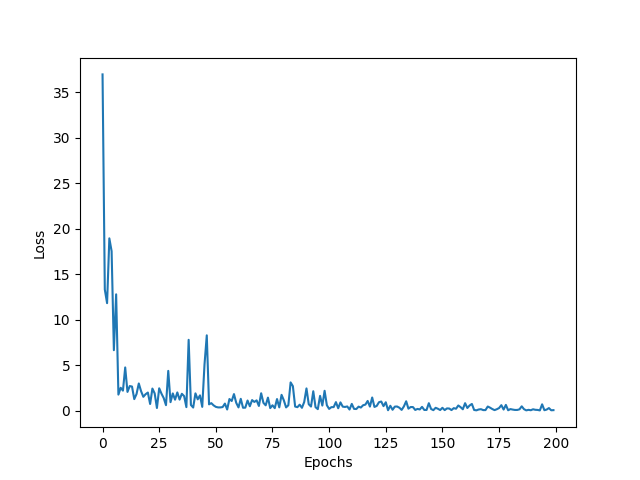

best epoch: 193, best loss: 0.013335862196981907


In [16]:
import torch.optim as optim

autoencoder = Autoencoder(input_dim, latent_dim)
autoencoder.to(device)

ego_tensors = torch.from_numpy(ego_vectors).to(device)
ego_tensors = ego_tensors.type(torch.FloatTensor)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1E-3) #1E-4
# add a learning rate scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Train the autoencoder
num_epochs = EPOCHS
batch_size = BATCH_SIZE

loss_recorder= []
min_loss = 1000000
for epoch in range(num_epochs):
    # Shuffle the data
    indices = torch.randperm(ego_tensors.size(0))
    shuffled_ego_tensors = ego_tensors[indices]
    
    # Split the data into batches
    num_batches = len(shuffled_ego_tensors) // batch_size
    for i in range(num_batches):
        # Get a batch of data
        batch = shuffled_ego_tensors[i * batch_size: (i + 1) * batch_size]
        
        # Move the batch to CUDA if available
        batch = batch.to(device)
        
        
        # Forward pass
        _, output = autoencoder(batch)
        
        # Compute the loss
        loss = criterion(output, batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # save best weights
    if loss.item() < min_loss:
        min_loss = loss.item()
        torch.save(autoencoder.state_dict(), 'best_model_task1.pth')
        print('model saved')
        best_epoch = epoch    
    # Decay the learning rate
    # scheduler.step()

    # add loss
    loss_recorder.append(loss.item())
    
    # Print the loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")#, Learning rate: {scheduler.get_lr()[0]:.8f}")

# Plot the loss
plt.plot(loss_recorder)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

print(f"best epoch: {best_epoch}, best loss: {min_loss}" )


## Run K-Means on the Latent Space
Now, lets pass the BoW representing each image and get the latent space representation. We will then run K-Means on the latent space, and use cosine similarity to classify the images.

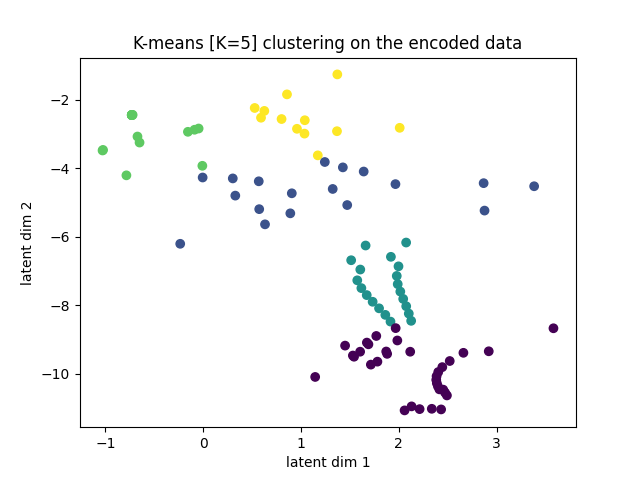

In [18]:
# Load the best model
autoencoder.load_state_dict(torch.load('best_model_task1.pth'))
autoencoder.to(device)
# use for inference
autoencoder.eval()

# Encode the data
encoded_data, _ = autoencoder(ego_tensors.to(device))
encoded_data = encoded_data.detach().cpu().numpy()


# Run k-means on the encoded data
kmeans = KMeans(n_clusters=K, random_state=0).fit(encoded_data)

# Plot the encoded data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(encoded_data[:,0], encoded_data[:,1], c=kmeans.labels_, marker='o')
ax.set_xlabel('latent dim 1')
ax.set_ylabel('latent dim 2')
plt.title('K-means [K=5] clustering on the encoded data')
plt.show()

### Store the images according to their clusters
Each image will be stored under `/task_1/cluster_i` where i is the cluster number the image belongs to.

In [6]:
import os
import shutil
os.makedirs('task_1', exist_ok=True)

data_path = "/DATA/Autobrains/EON/Images/"
# find the cluster of each image and copy it to a folder
for image_id, cluster in enumerate(kmeans.labels_):
    cluster = int(cluster)   
    image_path = image_index_to_id[image_id] + ".png"
    if os.path.exists(data_path + image_path):
        os.makedirs(f'task_1/{cluster}', exist_ok=True)
        shutil.copy(data_path + image_path, f'task_1/{cluster}/'+image_path)

    else: 
        print(f'Image {data_path + image_path} not found')
        
        